In [ ]:
# install libraries
!pip install transformers[torch] datasets accelerate torch sentencepiece peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large", device_map="auto")

input_text = "translate English to German: How old are you?"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to("cuda")

outputs = model.generate(input_ids)
print(tokenizer.decode(outputs[0]))



tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

<pad> Wie alte sind Sie?</s>


In [1]:
# import libraries
import numpy as np
import pandas as pd

In [2]:
# connecting google drive to colab
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# reading train and test data
%cd /content/drive/My Drive/Deakin_units/T1-2025/SIT764/sentiment-analysis/

/content/drive/My Drive/Deakin_units/T1-2025/SIT764/sentiment-analysis


In [ ]:
##config.py
%%writefile config.py
from dataclasses import dataclass

@dataclass
class ModelConfig:
    # model configurations
    model_name: str = "google/flan-t5-large"
    num_labels: int = 3  # positive, negative, neutral

    # training configurations
    learning_rate: float = 1e-4
    batch_size: int = 4  # small batch size for Colab
    epochs: int = 5

    # LoRA configurations
    lora_r: int = 16
    lora_alpha: int = 32
    lora_dropout: float = 0.1

    # paths
    train_data_path: str = "data/new_train.csv"
    test_data_path: str = "data/new_test.csv"

    # Output
    output_dir: str = "sentiment_model"

Overwriting config.py


In [ ]:
%%writefile src/data_loader.py

import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from config import ModelConfig
import pickle

class SentimentDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': self.labels[idx]
        }

def tokenize_and_cache_data(datapath, tokenizer, max_length=128, cache_dir='/content/drive/My Drive/Deakin_units/T1-2025/SIT764/sentiment-analysis/cached_data'):
    """
    Tokenize data and save to cache for faster loading

    Args:
    - datapath (str): Path to CSV file
    - tokenizer (AutoTokenizer): Tokenizer to use
    - max_length (int): Maximum sequence length
    - cache_dir (str): Directory to save cached files

    Returns:
    - Tuple of (input_ids, attention_masks, labels)
    """
    # Create cache directory if it doesn't exist
    os.makedirs(cache_dir, exist_ok=True)

    # Generate cache filename
    cache_filename = os.path.basename(datapath).replace('.csv', '_tokenized.pkl')
    cache_path = os.path.join(cache_dir, cache_filename)

    # Check if cached file exists
    if os.path.exists(cache_path):
        print(f"Loading cached tokenized data from {cache_path}")
        with open(cache_path, 'rb') as f:
            return pickle.load(f)

    # Read CSV
    df = pd.read_csv(datapath)

    # Prepare texts and labels
    texts = df['commentsReview'].tolist()

    # Map labels to integers
    label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
    labels = [label_map[label.lower()] for label in df['sentiment']]

    # Tokenize texts
    encodings = tokenizer(
        texts,
        return_tensors='pt',
        max_length=max_length,
        padding='max_length',
        truncation=True
    )

    # Extract input_ids and attention_masks
    input_ids = encodings['input_ids']
    attention_masks = encodings['attention_mask']

    # Convert to tensor
    labels = torch.tensor(labels, dtype=torch.long)

    # Cache the tokenized data
    cached_data = (input_ids, attention_masks, labels)
    with open(cache_path, 'wb') as f:
        pickle.dump(cached_data, f)

    print(f"Tokenized data cached to {cache_path}")
    return cached_data

def create_dataloaders(config, tokenizer):
    # Tokenize and cache train data
    train_input_ids, train_attention_masks, train_labels = tokenize_and_cache_data(
        config.train_data_path,
        tokenizer
    )

    # Tokenize and cache test data
    test_input_ids, test_attention_masks, test_labels = tokenize_and_cache_data(
        config.test_data_path,
        tokenizer
    )

    # Create datasets
    train_dataset = SentimentDataset(
        train_input_ids,
        train_attention_masks,
        train_labels
    )
    test_dataset = SentimentDataset(
        test_input_ids,
        test_attention_masks,
        test_labels
    )

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=config.batch_size,
        shuffle=False
    )

    return train_loader, test_loader

Writing src/data_loader.py


In [ ]:
# model configuration

%%writefile src/model.py

import torch
from transformers import AutoModelForSequenceClassification
from peft import LoraConfig, get_peft_model, TaskType

def create_model(config):
    # Load pre-trained model
    model = AutoModelForSequenceClassification.from_pretrained(
        config.model_name,
        num_labels=config.num_labels
    )

    # LoRA configuration
    lora_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=config.lora_r,
        lora_alpha=config.lora_alpha,
        lora_dropout=config.lora_dropout,
        target_modules=['q', 'v']  # Typically query and value projection layers
    )

    # Apply LoRA
    peft_model = get_peft_model(model, lora_config)

    return peft_model

def count_trainable_parameters(model):
    trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad
    )
    total_params = sum(p.numel() for p in model.parameters())

    print(f"Trainable parameters: {trainable_params}")
    print(f"Total parameters: {total_params}")
    print(f"Percentage of trainable parameters: {trainable_params/total_params*100:.2f}%")

Writing src/model.py


In [ ]:
# training script

%%writefile src/train.py

import torch
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm

def train_epoch(model, train_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc="Training"):
        # move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # zero gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        total_loss += loss.item()

        # backward pass
        loss.backward()
        optimizer.step()
        scheduler.step()

    return total_loss / len(train_loader)

def train_model(model, train_loader, test_loader, config, device):
    # Prepare optimizer and schedule
    optimizer = AdamW(
        model.parameters(),
        lr=config.learning_rate
    )

    # Total training steps
    total_steps = len(train_loader) * config.epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=total_steps // 10,
        num_training_steps=total_steps
    )

    best_accuracy = 0

    for epoch in range(config.epochs):
        print(f"Epoch {epoch+1}/{config.epochs}")

        # Training
        train_loss = train_epoch(
            model, train_loader, optimizer, scheduler, device
        )

        # Evaluation
        val_results = evaluate_model(
            model, test_loader, device
        )

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Validation Accuracy: {val_results['accuracy']:.4f}")

        # Save best model
        if val_results['accuracy'] > best_accuracy:
            best_accuracy = val_results['accuracy']
            model.save_pretrained(config.output_dir)
            print(f"New best model saved with accuracy: {best_accuracy:.4f}")

    return model

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Import evaluation metrics here to avoid circular imports
    from sklearn.metrics import (
        accuracy_score,
        precision_score,
        recall_score,
        f1_score,
        confusion_matrix
    )

    results = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, average='weighted'),
        'recall': recall_score(all_labels, all_preds, average='weighted'),
        'f1_score': f1_score(all_labels, all_preds, average='weighted'),
        'confusion_matrix': confusion_matrix(all_labels, all_preds)
    }

    return results

Writing src/train.py


In [4]:
# reading train and test data
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [5]:
train.shape

(3107, 9)

In [6]:
test.shape

(1036, 9)

In [ ]:
train.head(10)

,Column1,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above
5,2372,propecia,1,Ineffective,Severe Side Effects,hair loss,"after taking propecia for over a year, startin...","Low sex drive, before i started taking this dr...",one pill once daily
6,1043,vyvanse,9,Highly Effective,Mild Side Effects,add,"My mood has noticably improved, I have more en...","a few experiences of nausiea, heavy moodswings...",I had began taking 20mg of Vyvanse for three m...
7,2715,elavil,10,Considerably Effective,No Side Effects,depression,Although this drug was originally prescribed f...,None.,"One a day, taken about an hour before bedtime."
8,1591,xanax,10,Highly Effective,No Side Effects,panic disorder,This simply just works fast and without any of...,I really don't have any side effects other tha...,I first started taking this at 3 times per day...
9,1686,claritin,1,Ineffective,Extremely Severe Side Effects,allergies,none - did nothing to help allergies. i just h...,I had some horrifying mental and physical side...,took one 10 mg pill nightly.


In [ ]:
train['rating'].value_counts()

,count
rating,
10,742
8,558
9,480
7,350
1,305
5,159
6,157
3,146
4,107


In [ ]:
train['urlDrugName'].value_counts()

,count
urlDrugName,
lexapro,63
prozac,46
zoloft,45
retin-a,45
synthroid,38
...,...
desonide,1
nasacort-aq,1
glucophage-xr,1


In [ ]:
train['effectiveness'].value_counts()

,count
effectiveness,
Highly Effective,1330
Considerably Effective,928
Moderately Effective,415
Ineffective,247
Marginally Effective,187


In [ ]:
train[train["effectiveness"].isin(["Marginally Effective", "Moderately Effective"])][["rating", "effectiveness"]]

,rating,effectiveness
3,3,Marginally Effective
4,2,Marginally Effective
16,6,Moderately Effective
17,1,Marginally Effective
19,6,Moderately Effective
...,...,...
3090,3,Marginally Effective
3093,5,Marginally Effective
3096,7,Moderately Effective
3104,2,Marginally Effective


In [ ]:
train[train['rating']>7]

,Column1,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
6,1043,vyvanse,9,Highly Effective,Mild Side Effects,add,"My mood has noticably improved, I have more en...","a few experiences of nausiea, heavy moodswings...",I had began taking 20mg of Vyvanse for three m...
7,2715,elavil,10,Considerably Effective,No Side Effects,depression,Although this drug was originally prescribed f...,None.,"One a day, taken about an hour before bedtime."
8,1591,xanax,10,Highly Effective,No Side Effects,panic disorder,This simply just works fast and without any of...,I really don't have any side effects other tha...,I first started taking this at 3 times per day...
11,3479,dextroamphetamine,8,Highly Effective,Moderate Side Effects,add,Smoother more gradual onset and effect than Ad...,Dexerine IR tablets need to be taken more ofte...,Switched from Adderall to Dexedrine to compare...
...,...,...,...,...,...,...,...,...,...
3098,2148,zyrtec,10,Highly Effective,No Side Effects,"hives, itching, swelling due to allergies",No allergic reactions while taking daily doses...,NaN,My son had been having terrible problems with ...
3099,2613,adderall-xr,8,Considerably Effective,Moderate Side Effects,adhd,The medication helped the patient focus on dai...,"The patient experienced some side-effects, inc...",The patient was diagnosed with ADHD after desc...
3101,3485,diazepam,8,Considerably Effective,No Side Effects,muscle relaxant - spinal disorder,Reduced muscular tension allowing for easier s...,only down side was it made waking up in the mo...,To reduce pain generated by nerve irritation d...
3102,1039,vyvanse,10,Highly Effective,Mild Side Effects,adhd,"Increased focus, attention, productivity. Bett...","Restless legs at night, insomnia, headache (so...","I took adderall once as a child, and it made m..."


In [ ]:
train[(train['effectiveness']=='Moderately Effective') & (train['rating']==7)]

,Column1,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
32,1268,provigil,7,Moderately Effective,Mild Side Effects,fatigue,I was more alert during the first part of the ...,It may cause some nervousness or restlessness....,I took modafinil for cronic fatigue and genera...
119,1278,provigil,7,Moderately Effective,Mild Side Effects,fatigue not being able to get up in am,When I started first taking it it was great. I...,I am not sure if this is from the provigil or ...,I just take one 200mg every morning when I get...
138,2097,renova,7,Moderately Effective,Moderate Side Effects,acne,Wrinles seemed less defined,"Rash, red eyes",Apply once dayly
172,1524,glucophage,7,Moderately Effective,Moderate Side Effects,diabetes,helped lower blood sugar,"severe ankle swelling, stomach pain",Took Metformin (2) times along with Actos. Low...
191,1861,augmentin,7,Moderately Effective,No Side Effects,sinus infection,"Seem to have a bad sinus / nasal infection, no...",None. I do pretty well on penicillin type drugs.,Given to me by my PCP for sinus infection.
...,...,...,...,...,...,...,...,...,...
3061,4027,glucophage-xr,7,Moderately Effective,Severe Side Effects,polycystic ovary syndrome,"Less acne. It didn't disappear, though. And a ...",Eye and skin photosensitivity to sunlight and ...,"I took 2 pills, of 750 mg each of Glucophage X..."
3063,3131,duragesic,7,Moderately Effective,Mild Side Effects,cancer/constant pain,Having a constant level of pain relief by tran...,After 6-16 hours I became quite sleepy and tir...,Apply the patch every 3 days.
3077,2305,lexapro,7,Moderately Effective,Mild Side Effects,anxiety and depression,"more relaxed and not so obsessive, i did not h...",loose bowels. some say i was not as much fun o...,I was given this drug b/c of feelings of sadne...
3085,801,ambien,7,Moderately Effective,No Side Effects,sleep,to get restful sleep,"sleepiness, drowiness, etc",swallow the pill with water before bed. I was ...


In [ ]:
# labeling rates to positive, neutral and negative
def classify_label(rating):
  if rating>=7:
    return "positive"
  elif rating>=5:
    return "neutral"
  else:
    return "negative"

In [ ]:
train = train.dropna(subset=['commentsReview'])
test = test.dropna(subset=['commentsReview'])

In [ ]:
train['sentiment'] = train['rating'].apply(classify_label)
train.head(20)

,Column1,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview,sentiment
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ...",negative
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest...",negative
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...,positive
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...,negative
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above,negative
5,2372,propecia,1,Ineffective,Severe Side Effects,hair loss,"after taking propecia for over a year, startin...","Low sex drive, before i started taking this dr...",one pill once daily,negative
6,1043,vyvanse,9,Highly Effective,Mild Side Effects,add,"My mood has noticably improved, I have more en...","a few experiences of nausiea, heavy moodswings...",I had began taking 20mg of Vyvanse for three m...,positive
7,2715,elavil,10,Considerably Effective,No Side Effects,depression,Although this drug was originally prescribed f...,None.,"One a day, taken about an hour before bedtime.",positive
8,1591,xanax,10,Highly Effective,No Side Effects,panic disorder,This simply just works fast and without any of...,I really don't have any side effects other tha...,I first started taking this at 3 times per day...,positive
9,1686,claritin,1,Ineffective,Extremely Severe Side Effects,allergies,none - did nothing to help allergies. i just h...,I had some horrifying mental and physical side...,took one 10 mg pill nightly.,negative


In [ ]:
test['sentiment'] = test['rating'].apply(classify_label)
test.head()

,Column1,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview,sentiment
0,1366,biaxin,9,Considerably Effective,Mild Side Effects,sinus infection,The antibiotic may have destroyed bacteria cau...,"Some back pain, some nauseau.",Took the antibiotics for 14 days. Sinus infect...,positive
1,3724,lamictal,9,Highly Effective,Mild Side Effects,bipolar disorder,Lamictal stabilized my serious mood swings. On...,"Drowsiness, a bit of mental numbness. If you t...",Severe mood swings between hypomania and depre...,positive
2,3824,depakene,4,Moderately Effective,Severe Side Effects,bipolar disorder,Initial benefits were comparable to the brand ...,"Depakene has a very thin coating, which caused...",Depakote was prescribed to me by a Kaiser psyc...,negative
3,969,sarafem,10,Highly Effective,No Side Effects,bi-polar / anxiety,It controlls my mood swings. It helps me think...,I didnt really notice any side effects.,This drug may not be for everyone but its wond...,positive
4,696,accutane,10,Highly Effective,Mild Side Effects,nodular acne,Within one week of treatment superficial acne ...,Side effects included moderate to severe dry s...,Drug was taken in gelatin tablet at 0.5 mg per...,positive


In [ ]:
train.to_csv("data/new_train.csv")

In [ ]:
test.to_csv("data/new_test.csv")

In [ ]:
train['sentiment'].value_counts()

,count
sentiment,
positive,1780
neutral,666
negative,661


In [ ]:
from datasets import Dataset

In [ ]:
train_dataset = Dataset.from_pandas(train)
test_dataset = Dataset.from_pandas(test)

In [ ]:
train_dataset

Dataset({
    features: ['Column1', 'urlDrugName', 'rating', 'effectiveness', 'sideEffects', 'condition', 'benefitsReview', 'sideEffectsReview', 'commentsReview', 'sentiment', '__index_level_0__'],
    num_rows: 3095
})

In [ ]:
test_dataset

Dataset({
    features: ['Column1', 'urlDrugName', 'rating', 'effectiveness', 'sideEffects', 'condition', 'benefitsReview', 'sideEffectsReview', 'commentsReview', 'sentiment', '__index_level_0__'],
    num_rows: 1035
})

In [ ]:
torch.cuda.is_available()

True

In [ ]:
!pip install dataclasses

In [ ]:
from config import ModelConfig
from src.data_loader import create_dataloaders
from src.model import create_model, count_trainable_parameters
from src.train import train_model, evaluate_model

In [ ]:
import torch
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def main():
    # Configuration
    config = ModelConfig()

    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Tokenizer
    tokenizer = AutoTokenizer.from_pretrained(config.model_name)

    # Create Dataloaders
    train_loader, test_loader = create_dataloaders(config, tokenizer)

    # Create Model
    model = create_model(config)
    model.to(device)

    # Count Parameters
    count_trainable_parameters(model)

    # Train Model
    trained_model = train_model(
        model, train_loader, test_loader, config, device
    )

    # Final Evaluation
    results = evaluate_model(trained_model, test_loader, device)

    # Print Results
    print("\n--- Final Evaluation Results ---")
    for key, value in results.items():
        if key != 'confusion_matrix':
            print(f"{key}: {value}")

    # Plot Confusion Matrix
    plt.figure(figsize=(10,7))
    sns.heatmap(
        results['confusion_matrix'],
        annot=True,
        fmt='d',
        cmap='Blues'
    )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig(f"{config.output_dir}/confusion_matrix.png")

Using device: cuda
Tokenized data cached to /content/drive/My Drive/Deakin_units/T1-2025/SIT764/sentiment-analysis/cached_data/new_train_tokenized.pkl
Tokenized data cached to /content/drive/My Drive/Deakin_units/T1-2025/SIT764/sentiment-analysis/cached_data/new_test_tokenized.pkl


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at google/flan-t5-small and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: 688128
Total parameters: 61463939
Percentage of trainable parameters: 1.12%
Epoch 1/5


Evaluating: 100%|██████████| 259/259 [00:09<00:00, 28.62it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 1.0408
Validation Accuracy: 0.5275
New best model saved with accuracy: 0.5275
Epoch 2/5


Evaluating: 100%|██████████| 259/259 [00:09<00:00, 28.71it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 0.9787
Validation Accuracy: 0.5285
New best model saved with accuracy: 0.5285
Epoch 3/5


Evaluating: 100%|██████████| 259/259 [00:08<00:00, 28.86it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 0.9638
Validation Accuracy: 0.5275
Epoch 4/5


Evaluating: 100%|██████████| 259/259 [00:08<00:00, 30.66it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 0.9556
Validation Accuracy: 0.5275
Epoch 5/5


Evaluating: 100%|██████████| 259/259 [00:08<00:00, 31.41it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train Loss: 0.9465
Validation Accuracy: 0.5275


Evaluating: 100%|██████████| 259/259 [00:08<00:00, 28.99it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- Final Evaluation Results ---
accuracy: 0.527536231884058
precision: 0.3104723198284013
recall: 0.527536231884058
f1_score: 0.3687316526770183


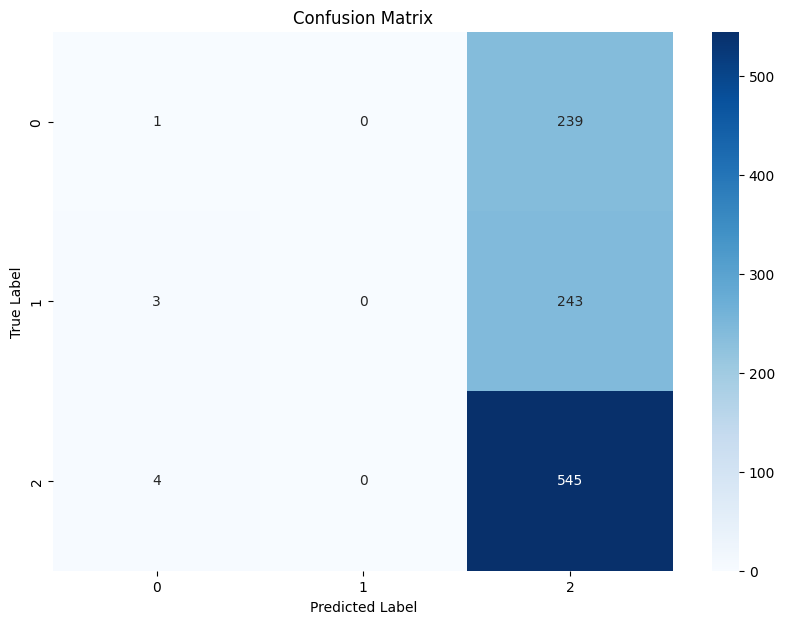

In [ ]:
if __name__ == "__main__":
    main()

In [1]:
!pip freeze > "/content/drive/My Drive/Deakin_units/T1-2025/SIT764/sentiment-analysis/requirements.txt"

/bin/bash: line 1: /content/drive/My Drive/Deakin_units/T1-2025/SIT764/sentiment-analysis/requirements.txt: No such file or directory
